# Modelo de submuestreo

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import os
from os import listdir
from os.path import isfile, join

## <font color=red>1. </font>Cargar las imágenes y los datos tabulares

In [3]:
# Resized images directory
dir_2019_images = "/kaggle/input/resizedsiimisic/train_resized/"

# CSV file
train_df = pd.read_csv('/kaggle/input/resizedsiimisic/train.csv')

In [4]:
train_df.head()

,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0000000.jpg,female,55.0,anterior torso,0.0
1,ISIC_0000001.jpg,female,30.0,anterior torso,0.0
2,ISIC_0000002.jpg,female,60.0,upper extremity,1.0
3,ISIC_0000003.jpg,male,30.0,upper extremity,0.0
4,ISIC_0000004.jpg,male,80.0,posterior torso,1.0


In [5]:
print("Train shape:", train_df.shape)

Train shape: (22480, 5)


## <font color=red>2. </font>Submuestreo de las imágenes mayoritarias

In [6]:
train_df.target.value_counts().rename_axis('Tipo').reset_index(name='Total de muestras')

,Tipo,Total de muestras
0,0.0,18134
1,1.0,4346


In [7]:
# Number of samples of majority class to delete
N = train_df.target.value_counts()[0] - train_df.target.value_counts()[1]

train_df = train_df.drop(train_df[train_df['target'].eq(0)].sample(N).index)

In [8]:
train_df.target.value_counts().rename_axis('Tipo').reset_index(name='Total de muestras')

,Tipo,Total de muestras
0,0.0,4346
1,1.0,4346


In [9]:
train_df.head()

,image_name,sex,age_approx,anatom_site_general_challenge,target
2,ISIC_0000002.jpg,female,60.0,upper extremity,1.0
3,ISIC_0000003.jpg,male,30.0,upper extremity,0.0
4,ISIC_0000004.jpg,male,80.0,posterior torso,1.0
12,ISIC_0000013.jpg,female,30.0,posterior torso,1.0
19,ISIC_0000020_downsampled.jpg,female,25.0,anterior torso,0.0


In [10]:
from collections import Counter
from sklearn.model_selection import train_test_split

X = train_df
y = train_df['target']

In [11]:
# Split into train, validation test and calibration sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=42)

X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, 
                                                    test_size=0.4,
                                                    stratify=y_test,
                                                    random_state=42)


print("Conjunto de train:", X_train.shape)
print("Conjunto de validacion:", X_val.shape)
print("Conjunto de prueba:", X_test.shape)
print("Conjunto de calibracion:", X_calib.shape)
print("-----------------------")
print('Distribucion de train ->', Counter(y_train))
print('Distribucion de validacion ->', Counter(y_val))
print("Distribucion de prueba:", Counter(y_test))
print("Distribucion de calibracion:", Counter(y_calib))

Conjunto de train: (5562, 5)
Conjunto de validacion: (1391, 5)
Conjunto de prueba: (1043, 5)
Conjunto de calibracion: (696, 5)
-----------------------
Distribucion de train -> Counter({1.0: 2781, 0.0: 2781})
Distribucion de validacion -> Counter({1.0: 696, 0.0: 695})
Distribucion de prueba: Counter({0.0: 522, 1.0: 521})
Distribucion de calibracion: Counter({1.0: 348, 0.0: 348})


In [12]:
X_train.to_csv('/kaggle/working/train.csv', index=False)
X_val.to_csv('/kaggle/working/val.csv', index=False)
X_calib.to_csv('/kaggle/working/calib.csv', index=False)
X_test.to_csv('/kaggle/working/test.csv', index=False)

In [13]:
X_train["target"] = X_train['target'].astype(str)
X_val["target"] = X_val['target'].astype(str)
X_calib["target"] = X_calib['target'].astype(str)
X_test["target"] = X_test['target'].astype(str)

## <font color=red>3. </font>Crear y entrenar el modelo

In [14]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

2021-12-01 15:19:31.123155: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [16]:
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=X_val,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

calib_generator=datagen.flow_from_dataframe(
    dataframe=X_calib,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_CALIB=calib_generator.n//calib_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 5562 validated image filenames belonging to 2 classes.
Found 1391 validated image filenames belonging to 2 classes.
Found 696 validated image filenames belonging to 2 classes.
Found 1043 validated image filenames belonging to 2 classes.


In [18]:
encoder = DenseNet121(input_shape=(None,None,3), 
                      include_top=False, 
                      weights='imagenet')

In [19]:
inputs = Input(shape=(None, None, 3))
x = encoder(inputs, training=False)
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model_undersampling = Model(inputs=inputs, outputs=predictions)

In [20]:
model_undersampling.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [21]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      AUC(name='auc')
]

In [22]:
checkpoint_filepath = '/kaggle/working/undersampling_model.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_auc',
                                            mode='max',
                                            verbose=1,
                                            save_best_only=True)

In [23]:
model_undersampling.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=METRICS
)

In [25]:
model_undersampling.fit(train_generator,  
                        validation_data =valid_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN, 
                        validation_steps=STEP_SIZE_VALID,
                        callbacks=[model_checkpoint_callback],
                        epochs = 100)

Epoch 1/100
173/173 [==============================] - 51s 296ms/step - loss: 0.6940 - tp: 878.0000 - fp: 908.0000 - tn: 1858.0000 - fn: 1886.0000 - auc: 0.4941 - val_loss: 0.6932 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 687.0000 - val_fn: 689.0000 - val_auc: 0.5000

Epoch 00001: val_auc did not improve from 0.51527
Epoch 2/100
173/173 [==============================] - 51s 297ms/step - loss: 0.6954 - tp: 1440.0000 - fp: 1382.0000 - tn: 1380.0000 - fn: 1328.0000 - auc: 0.5179 - val_loss: 2.2025 - val_tp: 691.0000 - val_fp: 685.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_auc: 0.3941

Epoch 00002: val_auc did not improve from 0.51527
Epoch 3/100
173/173 [==============================] - 51s 296ms/step - loss: 1.1627 - tp: 1306.0000 - fp: 1270.0000 - tn: 1501.0000 - fn: 1453.0000 - auc: 0.5082 - val_loss: 0.6952 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 685.0000 - val_fn: 691.0000 - val_auc: 0.5502

Epoch 00003: val_auc improved from 0.51527 to 0.55015, savi

## <font color=red>4. </font>Evaluar el modelo

In [120]:
eval_metrics = model_undersampling.evaluate(test_generator,
                                            steps=STEP_SIZE_TEST,
                                            return_dict=True,
                                            use_multiprocessing=False,
                                            verbose=1)

32/32 [==============================] - 4s 132ms/step - loss: 0.8363 - tp: 353.0000 - fp: 137.0000 - tn: 375.0000 - fn: 159.0000 - auc: 0.7870


In [121]:
calib_labels = calib_generator.classes
test_labels = test_generator.classes

predict_calib = model_undersampling.predict(calib_generator,
                                            verbose=1)
predict_test = model_undersampling.predict(test_generator,
                                           verbose=1)

33/33 [==============================] - 4s 111ms/step


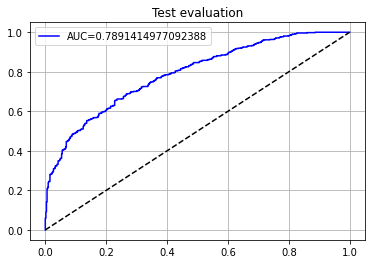

In [122]:
from sklearn import metrics

fpr, tpr, tr = metrics.roc_curve(test_labels, predict_test.ravel())
auc = metrics.roc_auc_score(test_labels, predict_test.ravel())
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation')
plt.grid()
plt.legend(loc='best')
plt.show()

#### Finalmente, se observa la matriz de confusión para el conjunto de prueba y calibración.

In [131]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(test_labels, np.where(np.array(predict_test.ravel()) > 0.5, 1, 0))
cm_test

array([[380, 142],
       [162, 359]])

Test dataset


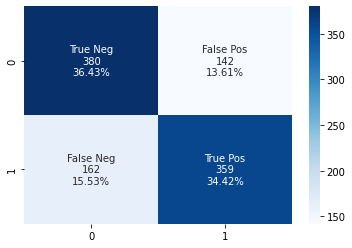

In [132]:
import seaborn as sns

cm = [cm_test[0][0], cm_test[0][1], cm_test[1][0], cm_test[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')
print("Test dataset")

In [133]:
cm_calib = confusion_matrix(calib_labels, np.where(np.array(predict_calib.ravel()) > 0.5, 1, 0))
cm_calib

array([[258,  90],
       [ 99, 249]])

Calibration dataset


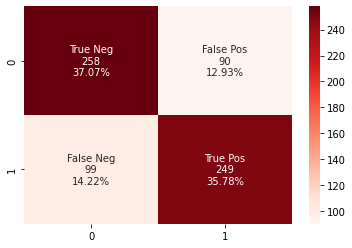

In [134]:
cm = [cm_calib[0][0], cm_calib[0][1], cm_calib[1][0], cm_calib[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Reds')
print("Calibration dataset")

In [136]:
under_test_predictions = {'Ground Truth': test_labels,
                          'Undersampling Classifier prediction': predict_test.ravel().astype(str)}

df_test_predictions = pd.DataFrame(under_test_predictions)
df_test_predictions.head()

,Ground Truth,Undersampling Classifier prediction
0,0,0.22006375
1,1,0.9999994
2,0,5.0115576e-13
3,1,0.9999515
4,0,0.80792683


In [137]:
under_calib_predictions = {'Ground Truth': calib_labels,
                           'Undersampling Classifier prediction': predict_calib.ravel().astype(str)}

df_calib_predictions = pd.DataFrame(under_calib_predictions)
df_calib_predictions.head()

,Ground Truth,Undersampling Classifier prediction
0,1,0.9874215
1,0,0.008577817
2,0,0.004195224
3,1,0.9955598
4,1,0.07049355


In [138]:
df_calib_predictions.to_csv('/kaggle/working/under_calib_predictions.csv', index=False)
df_test_predictions.to_csv('/kaggle/working/under_test_predictions.csv', index=False)